# Problem 1

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import kplr
import scipy.integrate as integrate
import scipy

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
time = hdu_data["time"] #get the time of each observation
flux = hdu_data["sap_flux"] #get the flux
flux_err = hdu_data["sap_flux_err"] #get the error in the flux
f.close()

# Extract data within time range 124 < t <  125 
index = np.where((time > 124) & (time < 125))

# Compute flux average F'
f_mean = np.mean(flux[index])

# Compute standard deviation sigma'
f_std = np.std(flux[index])


In [3]:
# Exclude transit 
def exclude_transit(mean, std, f) :
    
    f_mean = mean 
    f_std = std
        
    for i in range(5) : 
        sum_flux = 0
        total_flux = 0
        new_flux = []
        
        for x in f :
            if (abs(x - f_mean)/f_std) < 2 : 
                sum_flux += x
                total_flux += 1
                new_flux.append(x)
                
        f_mean = sum_flux / total_flux
        f_std = np.std(new_flux)
        
    return (f_mean, f_std)


In [4]:
def normalize(f_mean, flux, err) : 
    return (flux/f_mean, err/f_mean)    

import my_transit helper function and define func1 and func2, which are the two functions to be integrated to compute the flux theory curve (which is the ratio of the integral(func1)/integral(func2))

In [5]:
import my_transit

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - my_transit.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

In [6]:
def fluxGeneral(I, p, z, lowlim, upplim) : 
        (num_val, num_err) = integrate.quad(func1, lowlim, upplim, args=(p, z))
        (den_val, den_err) = integrate.quad(func2, lowlim, upplim, args=(p, z))
        return num_val/den_val

In [7]:
def t_to_z(t, tau, t0):
    return (t - t0)/tau

In [8]:
# Mean and std excluding transit
(mean_et, std_et) = exclude_transit(f_mean, f_std, flux[index])
(norm_flux, norm_err) = normalize(mean_et, flux[index], flux_err[index])

def chi_squared(norm_flux, norm_err, tau, t0, p): 
    sum_chi2 = 0 
    tmp_chi2 = 0
    count = 0
    
    z_range = []
    flux_range = []

    for t in time[index]: 
        z = t_to_z(t, tau, t0)
        z_range.append(z)
        f_tmp = fluxGeneral(I, p, z, 0, 1)
        flux_range.append(f_tmp)
        
        tmp_chi2 = ((norm_flux[count] - f_tmp)/norm_err[count])**2
        sum_chi2 += tmp_chi2
        count+= 1
        
    return (sum_chi2, flux_range)

In [9]:
# parmeters of flux formula
tau = 0.1
t0 = 124.51
p = 0.0775

(x2, flux_range) = chi_squared(norm_flux, norm_err, tau, t0, p)
print("Chi-squared: " + str(x2))

Chi-squared: 465.198692421


# Problem 2

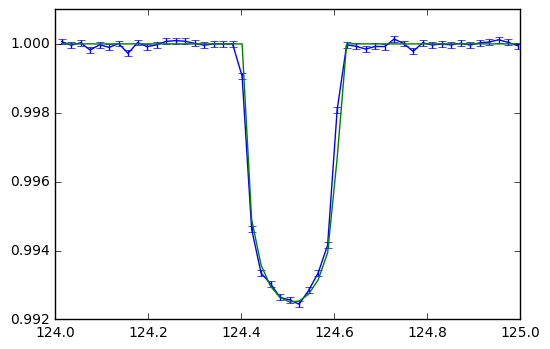

P-value: 3.50246323567e-69


In [9]:
# Plot data and predicted transit

plt.errorbar(time[index], norm_flux, norm_err)
plt.plot(time[index], flux_range)
plt.show()

p = scipy.special.gammaincc((len(norm_flux))/2, x2/2)
print("P-value: " + str(p))

By eye, this loos like a great fit. It seems as though the calculated flux are following the expected values almost exactly. However, if you look more closely you will notice that the value of p is actually 10 to the power of -70, indicating that the chances of getting this chi squared by chance is almost impossible. This shows that the data and the model are not a good fit at all. 

# Problem 3

Chi-squared: 465.198692421
Tau-minimized: 0.09999999999999999


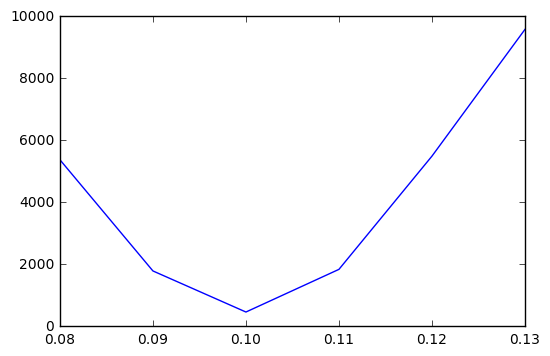

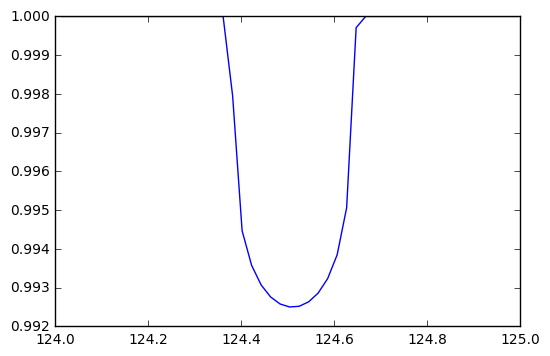

P-value: 1.0


In [10]:
# vary tau 

t0 = 124.51
p = 0.0775

chi2_list = []
tau_list = []
tau = 0.08
while tau <= 0.13:
    (x2, flux) = chi_squared(norm_flux, norm_err, tau, t0, p)
    chi2_list.append(x2)
    tau_list.append(tau)
    tau += 0.01
    
x2_min_in = np.argmin(chi2_list)
x2_min = chi2_list[x2_min_in]
tau_min = tau_list[x2_min_in]
print("Chi-squared: " + str(x2_min))
print("Tau-minimized: " + str(tau_min))

tau = tau_min
chi_squared(norm_flux, norm_err, tau, t0, p)

plt.plot(tau_list, chi2_list)                  
plt.show()
                  
plt.plot(time[index], flux)
plt.show()

p = scipy.special.gammainc((len(norm_flux) - 3)/2, x2_min/2)
print("P-value: " + str(p))

Chi squared minimized: 247.385162729
Tau minimized: 0.09700000000000002


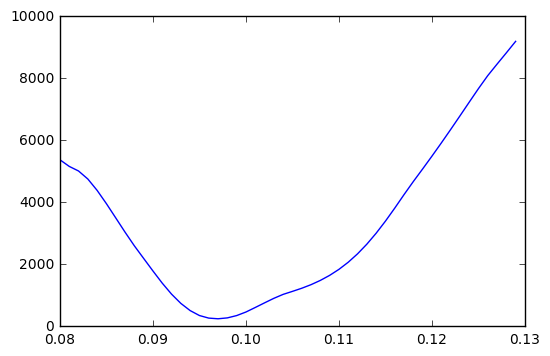

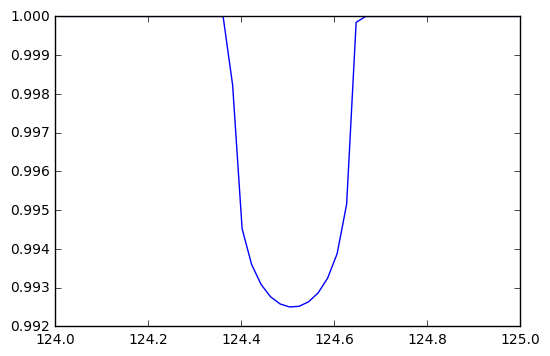

P-value: 2.21789461493e-29


In [11]:
# redo plotting more values

# vary tau 

t0 = 124.51
p = 0.0775

chi2_list = []
tau_list = []
tau = 0.08
while tau <= 0.13:
    (x2, flux) = chi_squared(norm_flux, norm_err, tau, t0, p)
    chi2_list.append(x2)
    tau_list.append(tau)
    tau += 0.001
    
x2_min_in = np.argmin(chi2_list)
x2_min = chi2_list[x2_min_in]
tau_min = tau_list[x2_min_in]
print("Chi squared minimized: " + str(x2_min))
print("Tau minimized: " + str(tau_min))

tau = tau_min
chi_squared(norm_flux, norm_err, tau, t0, p)

plt.plot(tau_list, chi2_list)                  
plt.show()
                  
plt.plot(time[index], flux)
plt.show()

p = scipy.special.gammaincc((len(norm_flux) - 3)/2, x2_min/2)
print("P-value: " + str(p))

Once minimizing tau, it is evident that this is a better fit than in Problem 2. The chi squared value has decreased by 50% and the p-value has increased by a power of 40. 


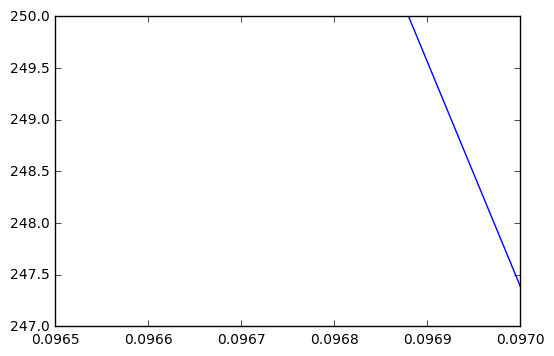

In [12]:
plt.plot(tau_list, chi2_list) 
plt.axis([0.0965, 0.097, 247, 250] )
plt.show()

For an original minimized chi-squared value of about 247.4, adding 1 gives a chi squared of 248.4 which corresponds to a tau value of about 0.09695. 

The unceratainty in tau is the difference between the original minimized tau and the one just calculated. 

In [13]:
uncertainty = abs(0.09695 - tau)
print("Uncertainty: " + str(uncertainty))

Uncertainty: 5.000000000002225e-05


# Problem 4

In [ ]:
# Vary all parameters simultaneously
# tau, t0, p

tau = 0.097
t0 = 124.45
p = 0.077
count = 0 

param_list = []

while tau <= 0.0975:
    t0 = 124.20
    while t0 <= 124.55:
        p = 0.08
        while p <= 0.085:
            (x2, flux) = chi_squared(norm_flux, norm_err, tau, t0, p)
            param_list.append((x2, (tau, t0, p)))
            count += 1
            print(count)
            print("(tau, t0, p) = " + str(tau) + "," + str(t0) + "," + str(p) )
            p += 0.001
        t0 += 0.02
    tau += 0.0001
    
print(count)
min(param_list)

The above found a minimized chi squared value of about 898.92. I will run again, varying my values a bit in order to cover a different range of values and hopefully find a smaller chi squared. 

In [ ]:
# Vary all parameters simultaneously
# tau, t0, p

tau = 0.0969
t0 = 124.51
p = 0.077
count = 0 

param_list = []

while tau <= 0.0973:
    t0 = 124.20
    while t0 <= 124.52:
        p = 0.08
        while p <= 0.080:
            (x2, flux) = chi_squared(norm_flux, norm_err, tau, t0, p)
            param_list.append((x2, (tau, t0, p)))
            count += 1
            print(count)
            print("(tau, t0, p) = " + str(tau) + "," + str(t0) + "," + str(p) )
            p += 0.001
        t0 += 0.001
    tau += 0.0001
    
print(count)
min(param_list)

The above found a minimized chi squared value of about 409.7. This value is better than what was found in Problem 2 but still higher than minimized value from Problem 3. I will run again, varying my values a bit in order to cover a different range of values and hopefully find a smaller chi squared. 

In [18]:
# Vary all parameters simultaneously
# tau, t0, p

tau = 0.0969
t0 = 124.50
p = 0.0798
count = 0 

param_list = []

while tau <= 0.0970:
    t0 = 124.50
    while t0 <= 124.51:
        p = 0.0798
        while p <= 0.0800:
            (x2, flux) = chi_squared(norm_flux, norm_err, tau, t0, p)
            param_list.append((x2, (tau, t0, p)))
            print(count)
            count += 1
            print("(tau, t0, p) = " + str(tau) + "," + str(t0) + "," + str(p) )
            p += 0.00005
        t0 += 0.001
    tau += 0.00001
    
print(count)
min(param_list)

0
(tau, t0, p) = 0.0969,124.5,0.0798
1
(tau, t0, p) = 0.0969,124.5,0.07984999999999999
2
(tau, t0, p) = 0.0969,124.5,0.07989999999999998
3
(tau, t0, p) = 0.0969,124.5,0.07994999999999998
4
(tau, t0, p) = 0.0969,124.5,0.07999999999999997
5
(tau, t0, p) = 0.0969,124.501,0.0798
6
(tau, t0, p) = 0.0969,124.501,0.07984999999999999
7
(tau, t0, p) = 0.0969,124.501,0.07989999999999998
8
(tau, t0, p) = 0.0969,124.501,0.07994999999999998
9
(tau, t0, p) = 0.0969,124.501,0.07999999999999997
10
(tau, t0, p) = 0.0969,124.50200000000001,0.0798
11
(tau, t0, p) = 0.0969,124.50200000000001,0.07984999999999999
12
(tau, t0, p) = 0.0969,124.50200000000001,0.07989999999999998
13
(tau, t0, p) = 0.0969,124.50200000000001,0.07994999999999998
14
(tau, t0, p) = 0.0969,124.50200000000001,0.07999999999999997
15
(tau, t0, p) = 0.0969,124.50300000000001,0.0798
16
(tau, t0, p) = 0.0969,124.50300000000001,0.07984999999999999
17
(tau, t0, p) = 0.0969,124.50300000000001,0.07989999999999998
18
(tau, t0, p) = 0.0969,124.5

(375.49713150982876, (0.0969, 124.50900000000004, 0.0798))

The above found a minimized chi squared value of about 375.49. This value is better than what was found in Problem 2 but still higher than minimized value from Problem 3. I will run again, varying my values a bit in order to cover a different range of values and hopefully find a smaller chi squared.

In [11]:
# Vary all parameters simultaneously
# tau, t0, p

tau = 0.09695
t0 = 124.505
p = 0.0798
count = 0 

param_list = []

while tau <= 0.0971:
    t0 = 124.505
    while t0 <= 124.515:
        p = 0.0798
        while p <= 0.0799:
            (x2, flux) = chi_squared(norm_flux, norm_err, tau, t0, p)
            param_list.append((x2, (tau, t0, p)))
            print(count)
            count += 1
            print("(tau, t0, p) = " + str(tau) + "," + str(t0) + "," + str(p) )
            p += 0.0001
        t0 += 0.001
    tau += 0.00001
    
print(count)
min(param_list)

0
(tau, t0, p) = 0.09695,124.505,0.0798
1
(tau, t0, p) = 0.09695,124.505,0.0799
2
(tau, t0, p) = 0.09695,124.506,0.0798
3
(tau, t0, p) = 0.09695,124.506,0.0799
4
(tau, t0, p) = 0.09695,124.507,0.0798
5
(tau, t0, p) = 0.09695,124.507,0.0799
6
(tau, t0, p) = 0.09695,124.50800000000001,0.0798
7
(tau, t0, p) = 0.09695,124.50800000000001,0.0799
8
(tau, t0, p) = 0.09695,124.50900000000001,0.0798
9
(tau, t0, p) = 0.09695,124.50900000000001,0.0799
10
(tau, t0, p) = 0.09695,124.51000000000002,0.0798
11
(tau, t0, p) = 0.09695,124.51000000000002,0.0799
12
(tau, t0, p) = 0.09695,124.51100000000002,0.0798
13
(tau, t0, p) = 0.09695,124.51100000000002,0.0799
14
(tau, t0, p) = 0.09695,124.51200000000003,0.0798
15
(tau, t0, p) = 0.09695,124.51200000000003,0.0799
16
(tau, t0, p) = 0.09695,124.51300000000003,0.0798
17
(tau, t0, p) = 0.09695,124.51300000000003,0.0799
18
(tau, t0, p) = 0.09695,124.51400000000004,0.0798
19
(tau, t0, p) = 0.09695,124.51400000000004,0.0799
20
(tau, t0, p) = 0.0969599999999999

(375.71432737144414, (0.09695, 124.50900000000001, 0.0798))

After several rounds of altering data, I have concluded that the brute force method is not the best way to minimize the chi squared value. In order to continue along the process I am in, I would need to individually use the values I have now for  tau, t0, and p, varying the other 2 parameters at one time. Iterating through more values than I have right now, is tedious since we start getting into 10^-4 powers of numbers to iterate through. 